In [1]:
!pip install nlp

     |████████████████████████████████| 1.7 MB 13.4 MB/s 
     |████████████████████████████████| 243 kB 51.7 MB/s 


In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nlp
import random

## Load dataset

In [3]:
dataset = nlp.load_dataset('emotion')

Downloading:   0%|          | 0.00/3.41k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/6.01k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/84e07cd366f4451464584cdbd4958f512bcaddb1e921341e07298ce8a9ce42f4. Subsequent calls will reuse this data.


In [4]:
dataset

{'test': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000),
 'train': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 16000),
 'validation': Dataset(features: {'text': Value(dtype='string', id=None), 'label': Value(dtype='string', id=None)}, num_rows: 2000)}

In [5]:
test = dataset['test']
train = dataset['train']
val = dataset['validation']

In [6]:
def get_tweet(data):
  tweets = [x['text'] for x in data]
  labels = [x['label'] for x in data]
  return tweets, labels

In [7]:
tweets, labels = get_tweet(train)

In [8]:
tweets[0], labels[0]

('i didnt feel humiliated', 'sadness')

## Data Pre-processing 

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer(num_words=10000, oov_token='<UNK>')
tokenizer.fit_on_texts(tweets)

In [10]:
tokenizer.texts_to_sequences([tweets[0]])

[[2, 139, 3, 679]]

In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def get_sequences(tokenizer, tweets):
  sequences = tokenizer.texts_to_sequences(tweets)
  padded = pad_sequences(sequences, truncating='post', padding='post', maxlen=maxlen)
  return padded

In [13]:
maxlen = 50
padded_train_seq = get_sequences(tokenizer, tweets)

In [14]:
padded_train_seq[0]

array([  2, 139,   3, 679,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [15]:
tweets[0]

'i didnt feel humiliated'

### Preparing the labels

In [16]:
classes = set(labels)
print(classes)

{'joy', 'sadness', 'surprise', 'fear', 'love', 'anger'}


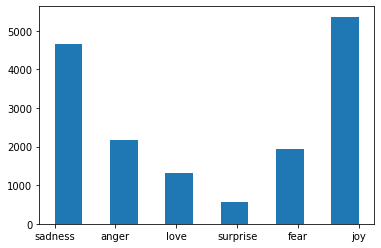

In [17]:
plt.hist(labels, bins=11)
plt.show()

In [18]:
classes_to_index = dict((c, i) for i, c in enumerate(classes))
index_to_class = dict((v, k) for k, v in classes_to_index.items())

In [19]:
classes_to_index

{'anger': 5, 'fear': 3, 'joy': 0, 'love': 4, 'sadness': 1, 'surprise': 2}

In [20]:
index_to_class

{0: 'joy', 1: 'sadness', 2: 'surprise', 3: 'fear', 4: 'love', 5: 'anger'}

In [21]:
name_to_ids = lambda labels: np.array([classes_to_index.get(x) for x in labels])

In [22]:
train_labels = name_to_ids(labels)

In [23]:
print(train_labels[0])

1


## Creating Model

In [24]:
model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(10000, 16, input_length=maxlen),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20, return_sequences=True)),
                             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(20)),
                             tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(loss = 'sparse_categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])


In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 16)            160000    
                                                                 
 bidirectional (Bidirectiona  (None, 50, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 6)                 246       
                                                                 
Total params: 175,926
Trainable params: 175,926
Non-trainable params: 0
_________________________________________________________________


In [26]:
val_tweets, val_labels = get_tweet(val)
val_seq = get_sequences(tokenizer, val_tweets)
val_labels = name_to_ids(val_labels)

In [27]:
val_tweets[0], val_labels[0]

('im feeling quite sad and sorry for myself but ill snap out of it soon', 1)

In [28]:
history = model.fit(
    padded_train_seq, train_labels,
    validation_data=(val_seq, val_labels),
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=2)]    
)

Epoch 1/20
500/500 [==============================] - 28s 45ms/step - loss: 1.2830 - accuracy: 0.5079 - val_loss: 0.7664 - val_accuracy: 0.7475
Epoch 2/20
500/500 [==============================] - 21s 42ms/step - loss: 0.5579 - accuracy: 0.8066 - val_loss: 0.5736 - val_accuracy: 0.8125
Epoch 3/20
500/500 [==============================] - 21s 43ms/step - loss: 0.3176 - accuracy: 0.8961 - val_loss: 0.4909 - val_accuracy: 0.8510
Epoch 4/20
500/500 [==============================] - 21s 43ms/step - loss: 0.2203 - accuracy: 0.9329 - val_loss: 0.4099 - val_accuracy: 0.8745
Epoch 5/20
500/500 [==============================] - 21s 43ms/step - loss: 0.1612 - accuracy: 0.9491 - val_loss: 0.4042 - val_accuracy: 0.8725
Epoch 6/20
500/500 [==============================] - 21s 42ms/step - loss: 0.1298 - accuracy: 0.9590 - val_loss: 0.4310 - val_accuracy: 0.8830
Epoch 7/20
500/500 [==============================] - 21s 42ms/step - loss: 0.1154 - accuracy: 0.9665 - val_loss: 0.4009 - val_accuracy:

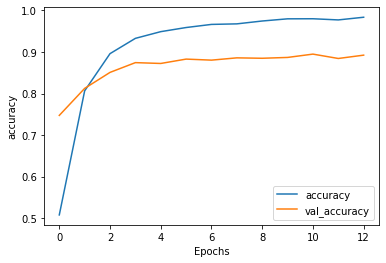

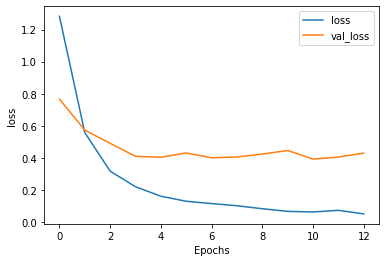

In [29]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [30]:
test_tweets, test_labels = get_tweet(test)
test_seq = get_sequences(tokenizer, test_tweets)
test_labels = name_to_ids(test_labels)

In [31]:
model.evaluate(test_seq, test_labels)

63/63 [==============================] - 1s 12ms/step - loss: 0.4689 - accuracy: 0.8820


[0.46886715292930603, 0.8820000290870667]

In [32]:
i = random.randint(0, len(test_labels) - 1)

print('sentence:', test_tweets[i])
print('emotion:', index_to_class[test_labels[i]])

p = model.predict(np.expand_dims(test_seq[i], axis=0))[0]
pred_class = index_to_class[np.argmax(p).astype('uint8')]

print('predicted emotion:', pred_class)

sentence: i lay in bed feeling as though i were awaiting an unwelcome visitor nevertheless i told myself i was strong and thought of good things until i felt better
emotion: sadness
predicted emotion: joy
